In [1]:
import firebase_admin
from firebase_admin import credentials, firestore
import  pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

/Users/lawrencefulton/PycharmProjects/test1/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
db_name = "chat"

In [3]:
cred = credentials.Certificate("serviceAccountKey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [4]:
chat = db.collection(db_name).get()


In [5]:
chat_list = []
for doc in chat:
    chat_list.append(doc.to_dict())
chat_df = pd.DataFrame(chat_list)
chat_df.head()




,0,questionTitle,1
0,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Erbschaftssteuer,"[{'questionID': 'p1', 'answerValue': 2}, {'que..."
1,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Erbschaftssteuer,"[{'questionID': 'p1', 'answerValue': 3}, {'que..."
2,"[{'questionID': 'p1', 'answerValue': 5}, {'que...",AfD-Verbot,"[{'questionID': 'p1', 'answerValue': 5}, {'que..."
3,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Tempolimit,"[{'questionID': 'p1', 'answerValue': 2}, {'que..."
4,"[{'questionID': 'p1', 'answerValue': 2}, {'que...",Erbschaftssteuer,"[{'questionID': 'p1', 'answerValue': 5}, {'que..."


In [6]:
#remove columns with empty values
chat_df = chat_df.dropna(subset=['1'])

# sace the data to a csv file
chat_df.to_csv(db_name + ".csv", index=False)

In [2]:
chat_df = pd.read_csv(db_name + ".csv")

FileNotFoundError: [Errno 2] No such file or directory: 'chat.csv'

In [7]:
def flatten_json_column(json_list, prefix):
    # Initialize an empty dictionary
    flattened_dict = {}

    # Iterate over each item in the list
    for item in json_list:
        # Extract questionID and answerValue and add to the dictionary with prefix
        flattened_dict[f"{prefix}_{item['questionID']}"] = item['answerValue']

    # Convert the dictionary to a pd.Series and return it
    return pd.Series(flattened_dict)

In [8]:
def get_premises(json_list, prefix):
    _premises = {}
    for item in json_list:
        try:
            _premises[f"{prefix}_premise_{item['questionID']}"] = item['questionText']
        except KeyError: 
            # add nan
            _premises[f"{prefix}_premise_{item['questionID']}"] = None 
        
    return  pd.Series(_premises)

In [9]:
def get_alternative_scale(json_list, prefix):
    _alternative_scale = {}
    for item in json_list:
        try:
            _alternative_scale[f"{prefix}_alternativeScale_{item['questionID']}"] = item['alternativeScale']
        except KeyError: 
            # add nan
            _alternative_scale[f"{prefix}_alternativeScale_{item['questionID']}"] = None 
        
    return  pd.Series(_alternative_scale)

In [10]:
flattened_0 = chat_df['0'].apply(flatten_json_column, prefix='0')
flattened_1 = chat_df['1'].apply(flatten_json_column, prefix='1')
premises_0 = chat_df['0'].apply(get_premises, prefix='0')
premises_1 = chat_df['1'].apply(get_premises, prefix='1')
alternative_scale_0 = chat_df['0'].apply(get_alternative_scale, prefix='0')
alternative_scale_1 = chat_df['1'].apply(get_alternative_scale, prefix='1')


# # Concatenate the flattened columns with the original DataFrame
df_flattened = pd.concat([chat_df.drop(columns=['0', '1']), flattened_0, flattened_1, premises_0, premises_1, alternative_scale_0, alternative_scale_1], axis=1)
df_flattened.head()

,questionTitle,0_p1,0_p2,0_p3,0_p4,0_p5,0_p6,0_p7,0_q0,0_p8,...,0_alternativeScale_p8,1_alternativeScale_p1,1_alternativeScale_p2,1_alternativeScale_p3,1_alternativeScale_p4,1_alternativeScale_p5,1_alternativeScale_p6,1_alternativeScale_p7,1_alternativeScale_q0,1_alternativeScale_p8
0,Erbschaftssteuer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,None,None,None,None,NaN,NaN,NaN,None,NaN
1,Erbschaftssteuer,1.0,2.0,4.0,1.0,4.0,NaN,NaN,2.0,NaN,...,NaN,None,None,None,None,NaN,NaN,NaN,None,NaN
2,AfD-Verbot,5.0,3.0,1.0,1.0,2.0,3.0,2.0,5.0,NaN,...,NaN,None,None,None,None,NaN,NaN,NaN,None,NaN
3,Tempolimit,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,...,NaN,None,None,None,None,NaN,NaN,NaN,None,NaN
4,Erbschaftssteuer,2.0,3.0,3.0,4.0,3.0,3.0,4.0,1.0,NaN,...,NaN,None,None,None,None,NaN,NaN,NaN,None,NaN


In [11]:
def plot_all_distributions(df):
    # Get all unique question titles
    question_titles = df['questionTitle'].unique()

    response_mapping = {
        0: 'Nein',
        1: 'Eher Nein',
        2: 'Neutral',
        3: 'Eher Ja',
        4: 'Ja'
    }
    
    axis_mapping = {
        'Mitbestimmung der Schüler*innen': 'Sollte an deiner Schule über ein Teil des Schuldbudgets ausschließlich von Schüler*innen entschieden werden?',
        'Nachhaltigkeit im Unterricht': 'Sollten in allen Fächern, sofern inhaltlich möglich, die Fachinhalte aus der Perspektive \nder Nachhaltigkeit reflektiert werden?',
        'Vegetarische Mensa': 'Sollte es nur noch vegetarisches Essen in deiner Schule geben?',
        'Autoverbot an Schulen': 'Sollte das Fahren, Bringen und Abholen zu deiner Schule mit dem \n Auto für alle verboten werden?'
    }
    
    # check if dir figures exists and if not create it 
    if not os.path.exists('figures'):
        os.makedirs('figures')
    


# Loop through each unique question title
    for question_title in question_titles:
        # Filter the DataFrame for the selected question title
        filtered_df = df.where(df['questionTitle'] == question_title)

        # Concatenate relevant columns
        responses = pd.concat([filtered_df['0_q0'], filtered_df['1_q0']])

        # Clean up the data
        responses = responses.dropna().astype(int)

        # Define the full range of response values (1 to 5 in this case)
        full_range = pd.Series(['Nein', 'Eher Nein', 'Neutral', 'Eher Ja', 'Ja'])

        # Map numeric values to categorical responses
        mapped_responses = responses.map(response_mapping)

        # Sort and count values, then reindex to fill missing values with 0
        hist = mapped_responses.value_counts().reindex(full_range, fill_value=0)        
        
        # Plot the distribution
        plt.figure(figsize=(10, 6))
        hist.plot(kind='bar')


        plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter())
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
        
        # Add a title dynamically
        # plt.xlabel('Antwort', fontsize=14)
        plt.ylabel('Anzahl der Meinungen', fontsize=14)
        plt.xticks(rotation=0)
        try:
            plt.title(axis_mapping[question_title], fontsize=16)
        except KeyError:
            plt.title(f'Verteilung bei der {question_title} Frage', fontsize=14)
            pass   
            

        
        # save
        plt.savefig(f'figures/{question_title}.png', dpi= 300)
        # plt.show() 
    

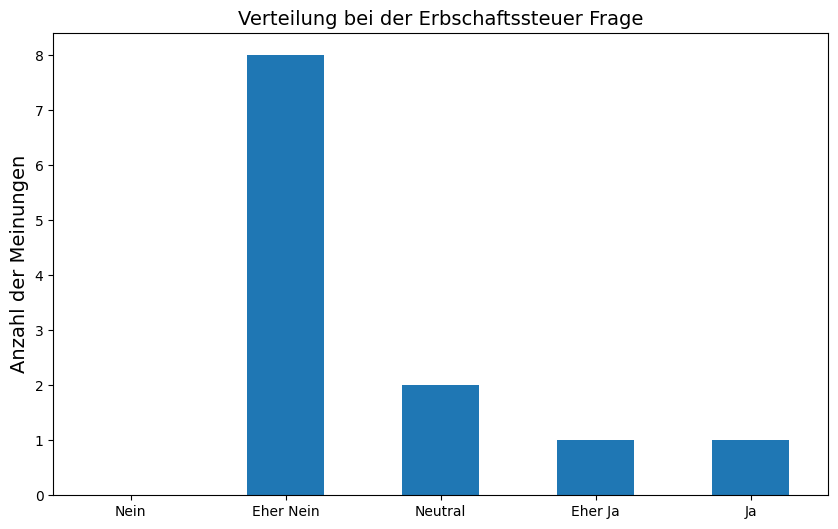

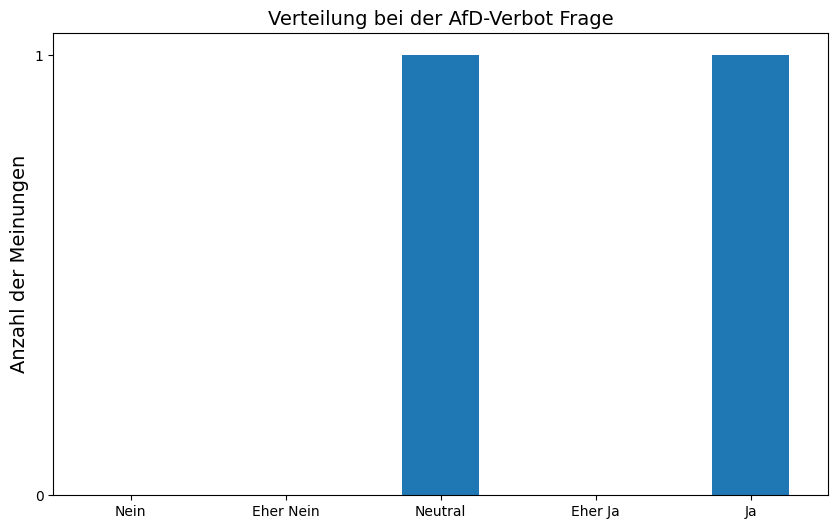

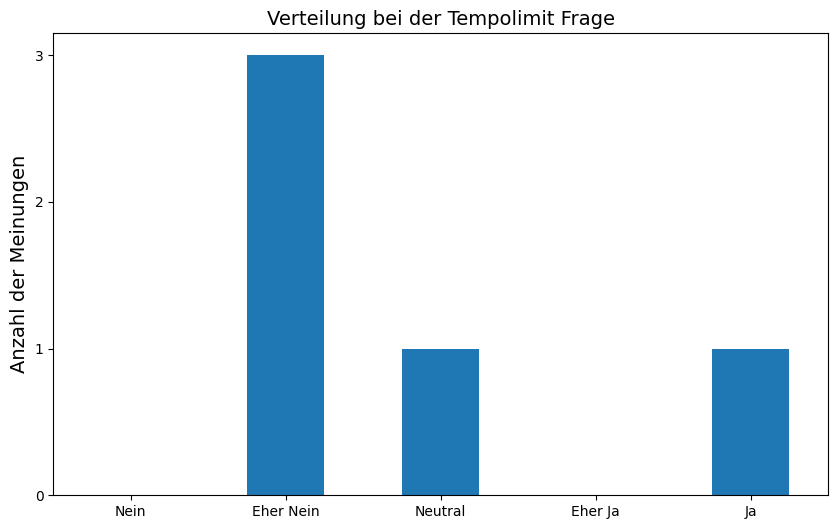

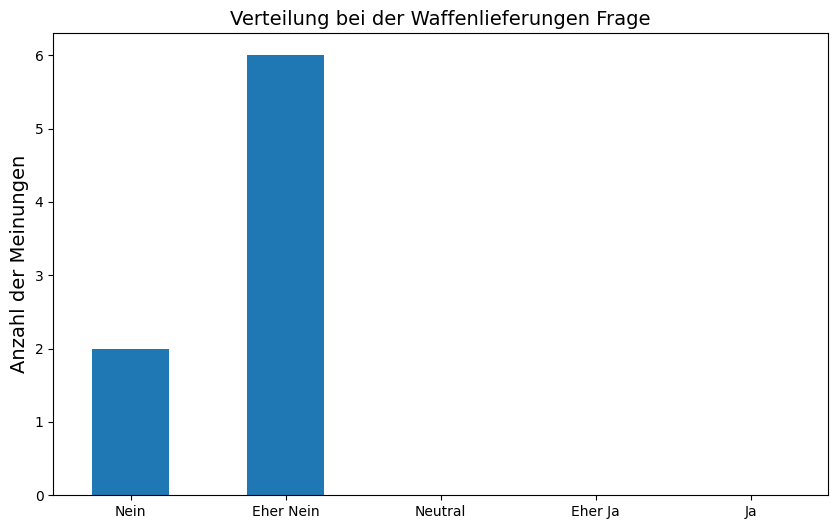

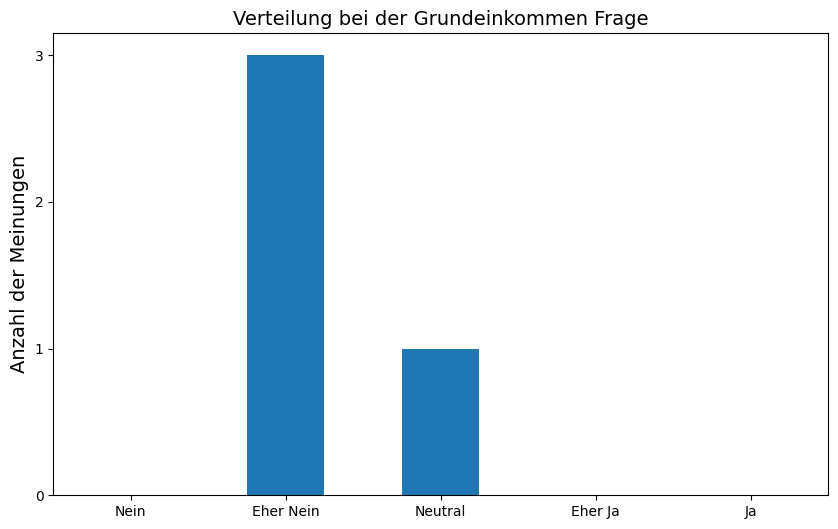

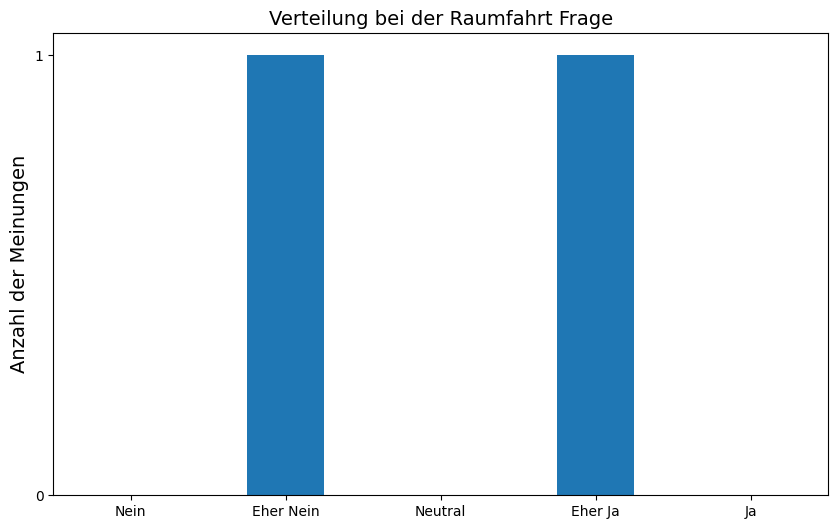

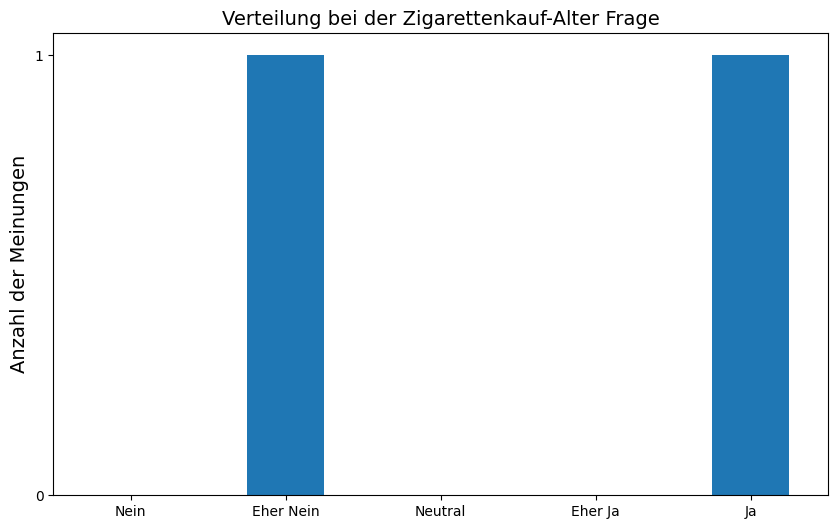

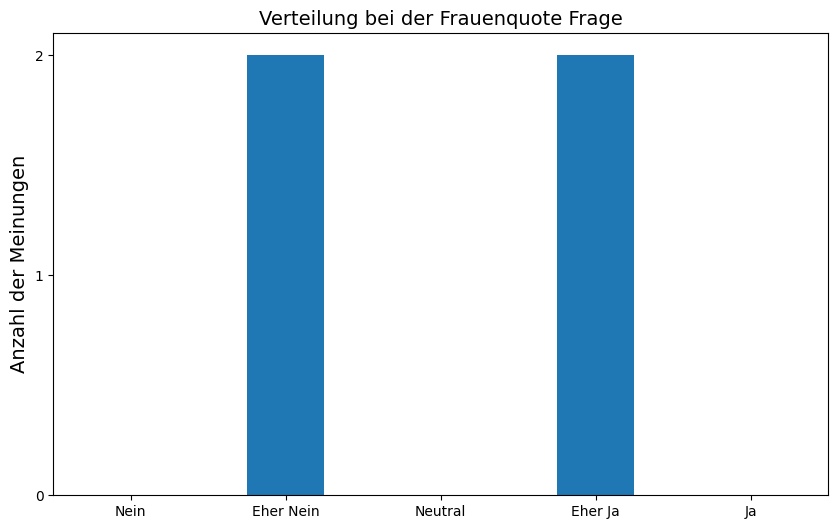

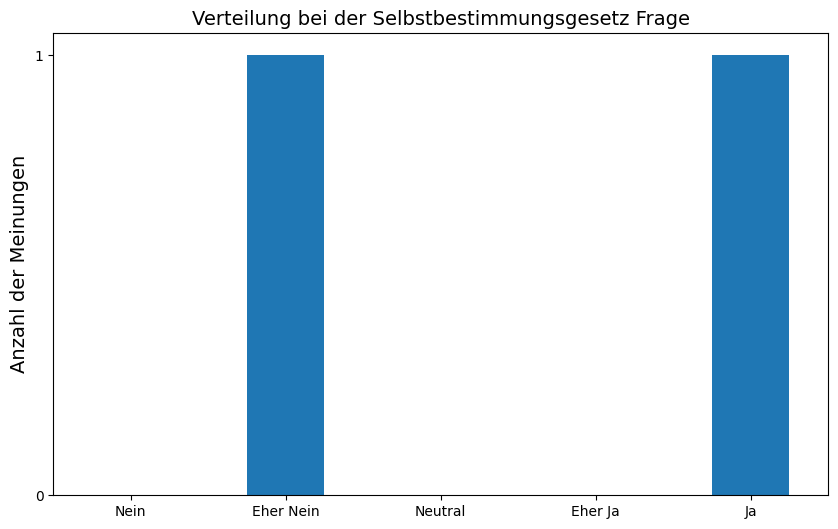

In [12]:
plot_all_distributions(df_flattened)

In [13]:
# for each question title plot the distribution of the premises 
# for this get the unique question titles
# then add 0_p$n and 1_p$n to the filtered_df 
# then concatenate the two columns
# then plot the distribution
# label the x-axis with the 0_premise_$questionID

def plot_all_premises(df):

    response_mapping = {
        0: 'Nein',
        1: 'Eher Nein',
        2: 'Neutral',
        3: 'Eher Ja',
        4: 'Ja'
    }
    # Get all unique question titles
    question_titles = df['questionTitle'].unique()
    
    # check if dir figures exists and if not create it 
    if not os.path.exists('figures'):
        os.makedirs('figures')
    
    
    
    for premise_idx in range(1, 8):
        premise_idx_str = str(premise_idx)
    
    # Loop through each unique question title
        for question_title in question_titles:
            # Filter the DataFrame for the selected question title
            filtered_df = df.where(df['questionTitle'] == question_title)
    
            # Concatenate relevant columns
            premises = pd.concat([filtered_df['0_p'+premise_idx_str], filtered_df['1_p'+premise_idx_str]])
            
            # if len == 0 continue
            if len(premises) == 0:
                continue
                
            
        
            premise_text = pd.concat([filtered_df['0_premise_p'+ premise_idx_str], filtered_df['1_premise_p'+premise_idx_str]])
            premise_text = premise_text.dropna()
            
            alternative_scales = pd.concat([filtered_df['0_alternativeScale_p' + premise_idx_str], filtered_df['1_alternativeScale_p' + premise_idx_str]])
            alternative_scales = alternative_scales.dropna()
            
            # get the # of premises_text and set the correct_premise_text to the one with the most occurences
            try:
                correct_premise_text = premise_text.value_counts().idxmax()
                
            except ValueError:
                continue
    
            
            try:
                correct_alternative_scale = alternative_scales.value_counts().idxmax()
            
            except ValueError:
                correct_alternative_scale = None            
            
    
            # Clean up the data
            premises = premises.dropna()
    
    
            if type(correct_alternative_scale) == list:
                
                full_range = pd.Series([correct_alternative_scale[0], 'Eher ' + correct_alternative_scale[0], 'Neutal', 'Eher '+ correct_alternative_scale[1] , correct_alternative_scale[1]])
                # map the responses to the correct alternative scale
                mapped_responses = premises.map({0: correct_alternative_scale[0], 1:  'Eher ' + correct_alternative_scale[0], 2: 'Neutal', 3: 'Eher ' + correct_alternative_scale[1], 4: correct_alternative_scale[1]})
                ## it should still show the 2,3,4 values in the plot
                
                
            else:
                full_range = pd.Series(['Nein', 'Eher Nein', 'Neutral', 'Eher Ja', 'Ja'])
                mapped_responses = premises.map(response_mapping)
    
    
    
        # Sort and count values, then reindex to fill missing values with 0
            hist = mapped_responses.value_counts().reindex(full_range, fill_value=0)        
            
            # Plot the distribution
            plt.figure(figsize=(10, 6))
            hist.plot(kind='bar')
    
            plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter())
            plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
            
            plt.ylabel('Anzahl der Meinungen', fontsize=14)
            plt.xticks(rotation=0)
            plt.title(correct_premise_text, fontsize=14)
            
            # save
            plt.savefig(f'figures/premises_{question_title}.png', dpi= 300)
            # plt.show()

In [15]:

plot_all_premises(df_flattened)